In [1]:
setwd('/import/DB/zhang//data')
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [2]:
SCE = readRDS('neu.final.rds')

In [3]:
Idents(SCE) ='celltype'

In [6]:
table(SCE$seurat_clusters,SCE$group)

   
      OS control
  0  497    1940
  1    8    2310
  2    5    2286
  3    0       0
  4    0       0
  5    0       0

In [7]:
SCE$celltype = paste0('Neu',SCE$seurat_clusters)

In [8]:
save(SCE,file = 'rename.neu.rda')

In [9]:
Idents(SCE) = 'celltype'

In [10]:
scRNA = subset(SCE,idents = 'Neu0')

Warning message:
"Scaling data with a low number of groups may produce misleading results"


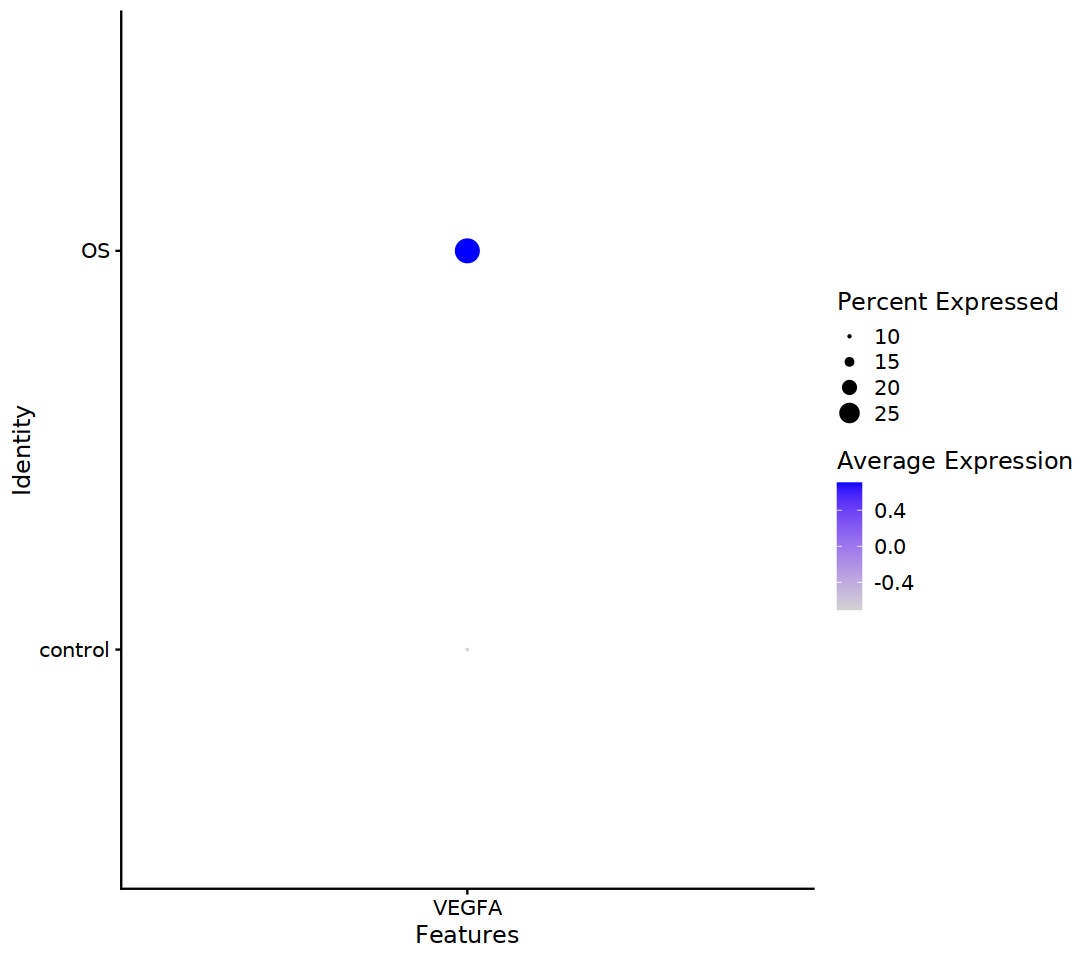

In [34]:
DotPlot(scRNA,features = 'VEGFA')

In [11]:
Idents(scRNA) = 'group'

In [12]:
Idents(scRNA) = 'group'
DefaultAssay(scRNA) = 'RNA'
sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

# library(dplyr) 
# # 不同seurat版本的 avg_logFC 不一样 
# top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)


Calculating cluster control

Calculating cluster OS



In [13]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(15, avg_log2FC)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [14]:
gene_cell_exp <- AverageExpression(scRNA,
                                   features = unique(top5$gene),
                                   group.by = 'group',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [15]:
gene_cell_exp = gene_cell_exp[,c('control',"OS")]

In [18]:
library(ComplexHeatmap)
#顶部细胞类型注释
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'

In [19]:
df$class = factor(df$class,levels = c('control',"OS"))

In [20]:
top_anno = HeatmapAnnotation(df = df,#细胞名/cluster
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c('control' = '#A0CCFF','OS'="#2F528F")))#颜色设置

In [21]:
#数据标准化缩放一下
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

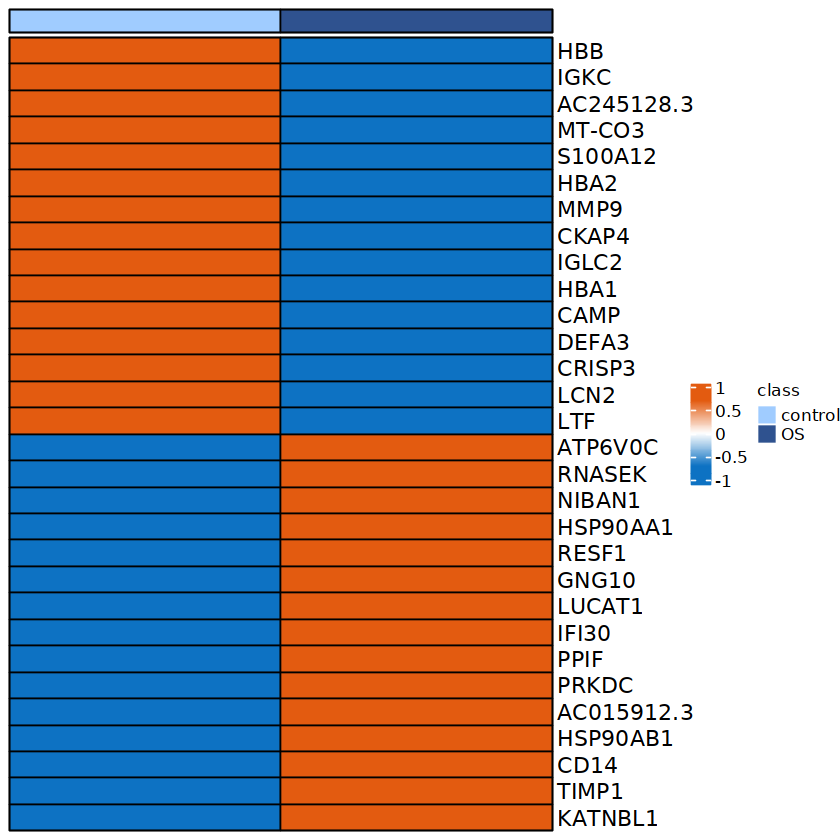

In [22]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)

In [24]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)
Idents(scRNA) <- "group" 
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)
# library(msigdbr)
# msigdbr_species() #列出有的物种

In [25]:
d = '/import/DB' 
gmtfs <- list.files(d,pattern = '.gmt')  # 路径下所有结尾为symbols.gmt文件
gmtfs
library(GSEABase)
kegg_list <- getGmt(file.path(d,gmtfs[3])) 
go_list <- getGmt(file.path(d,gmtfs[1])) 
hall_list <- getGmt(file.path(d,gmtfs[2])) 

[1] "BP.gmt"                   "h.all.v7.5.1.symbols.gmt"
[3] "kegg.gmt"

Warning message:
"package 'GSEABase' was built under R version 4.2.2"
Loading required package: annotate

Warning message:
"package 'annotate' was built under R version 4.2.2"
Loading required package: XML

Loading required package: graph

Warning message:
"package 'graph' was built under R version 4.2.3"

Attaching package: 'graph'


The following object is masked from 'package:XML':

    addNode


The following object is masked from 'package:stringr':

    boundary


Warning message in getGmt(file.path(d, gmtfs[1])):
"2 record(s) contain duplicate ids: GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT, GOBP_PROTEOLYSIS_INVOLVED_IN_PROTEIN_CATABOLIC_PROCESS"


In [26]:
human_KEGG_Set = hall_list
# #选择基因集合
# human_KEGG = msigdbr(species = "Homo sapiens", #物种
#                       category = "C2",
#                      subcategory = "KEGG") %>% 
#   dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
# human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)

library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

dim(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(10) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('HALLMARK_','',rownames(gsva.kegg))

rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,control,OS
HALLMARK_ADIPOGENESIS,0.15747616,0.12695096
HALLMARK_ALLOGRAFT_REJECTION,0.14082051,0.25643006
HALLMARK_ANDROGEN_RESPONSE,-0.06987241,0.41449589
HALLMARK_ANGIOGENESIS,-0.18194575,0.42228679
HALLMARK_APICAL_JUNCTION,0.03459608,0.08046919
HALLMARK_APICAL_SURFACE,-0.04551067,0.18738139


[1] 50  2

In [27]:
options(repr.plot.width = 5,repr.plot.height = 6)

Warning message:
"package 'pheatmap' was built under R version 4.2.3"

Attaching package: 'pheatmap'


The following object is masked from 'package:ComplexHeatmap':

    pheatmap




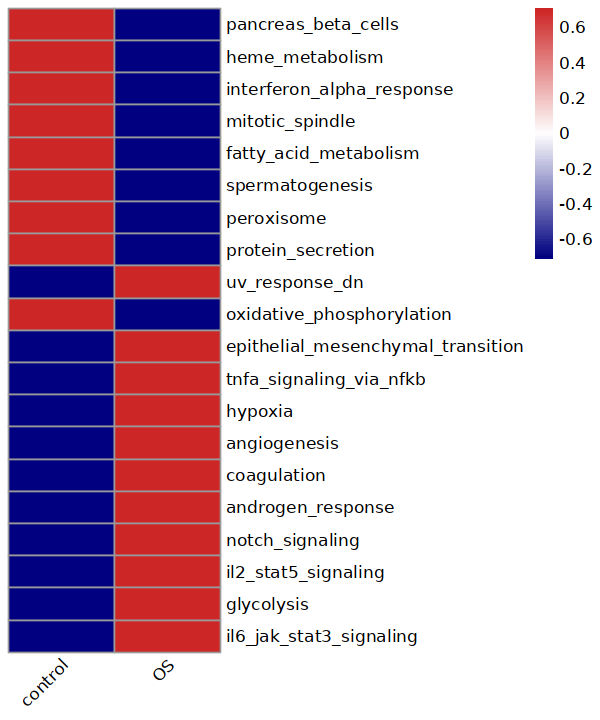

In [28]:
library(pheatmap)
p = pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))

### kegg

In [32]:
#human_KEGG_Set = kegg_list


library(msigdbr)
# #选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C2",
                     subcategory = "KEGG") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)

library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

dim(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(10) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('KEGG_','',rownames(gsva.kegg))

rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"package 'msigdbr' was built under R version 4.2.3"
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 186 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,control,OS
KEGG_ABC_TRANSPORTERS,-0.2390429065,-0.481769084
KEGG_ACUTE_MYELOID_LEUKEMIA,0.0004259718,0.113009028
KEGG_ADHERENS_JUNCTION,0.0320887736,-0.305091738
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,-0.2802256949,0.001157436
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,0.2434312070,0.320219519
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,0.0713280347,0.117322813


[1] 186   2

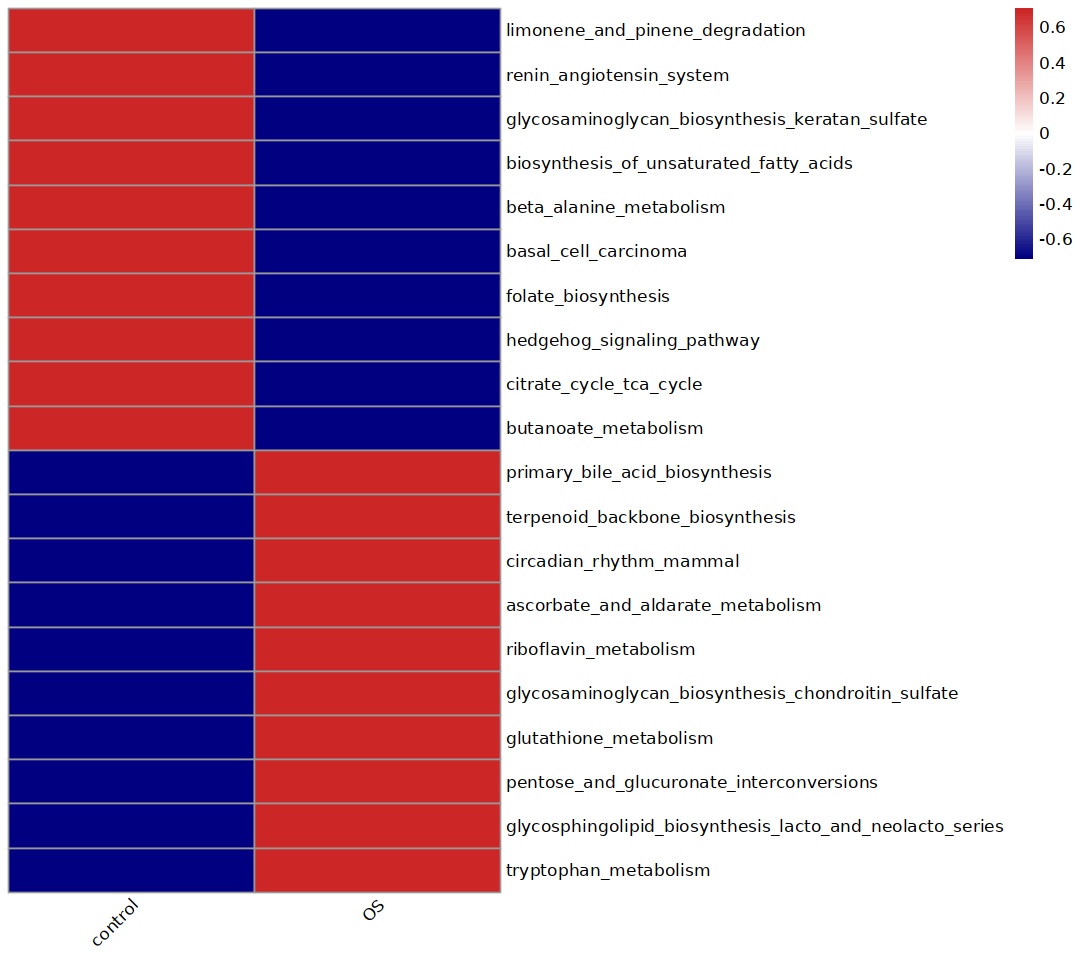

In [33]:
library(pheatmap)
p = pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))